In [1]:
# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

from utils import load_images, plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


# Parameters

In [2]:
train_dir = 'images_small/train/'
validation_dir = 'images_small/validation/'
test_dir = 'images_small/test/'

STD_SIZE = (100, 100)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

### Data preparation

In [3]:
classes = ['Chihuahua', 'Japanese_spaniel']
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 202 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 68 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (68, 100, 100, 3)


### Model

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=3e-5),
              metrics=['accuracy'])

W0708 18:45:04.042795  6888 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 18:45:04.060796  6888 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 18:45:04.063796  6888 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 18:45:04.075797  6888 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0708 18:45:04.146801  6888 depreca

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
__________

In [9]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_2', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_2_history', 'wb') as f:
    pickle.dump(history.history, f)

W0628 15:08:52.001344 140284202461056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/1000
 - 118s - loss: 0.6862 - acc: 0.5350 - val_loss: 0.6738 - val_acc: 0.5833

Epoch 00001: val_loss improved from inf to 0.67382, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_2
Epoch 2/1000
 - 1s - loss: 0.6754 - acc: 0.5404 - val_loss: 0.6661 - val_acc: 0.5957

Epoch 00002: val_loss improved from 0.67382 to 0.66608, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_2
Epoch 3/1000
 - 0s - loss: 0.6781 - acc: 0.5252 - val_loss: 0.6804 - val_acc: 0.4894

Epoch 00003: val_loss did not improve from 0.66608
Epoch 4/1000
 - 0s - loss: 0.6663 - acc: 0.5611 - val_loss: 0.6656 - val_acc: 0.5319

Epoch 00004: val_loss improved from 0.66608 to 0.66564, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_2
Epoch 5/1000
 - 0s - loss: 0.6566 - acc: 0.5706 - val_loss: 0.6609 - val_acc: 0.5667

Epoch 00005: val_loss improved from 0.66564 to 0.66089, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scr

### Results

In [10]:
model.evaluate(test_features, test_labels)

68/68 [==============================] - 0s 2ms/step


[0.44199668353094773, 0.8235294117647058]

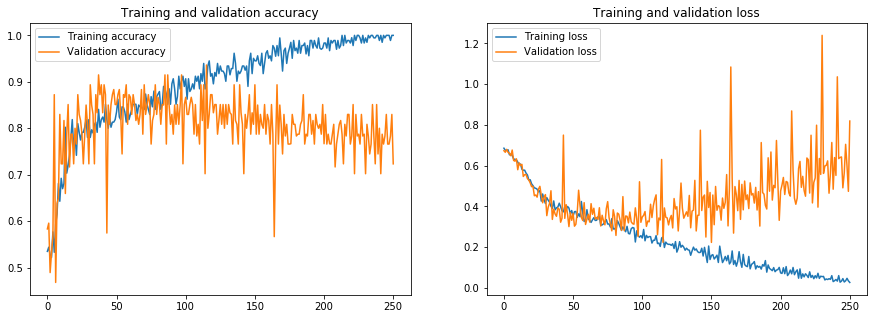

In [11]:
plot_accuracy_and_loss(history)

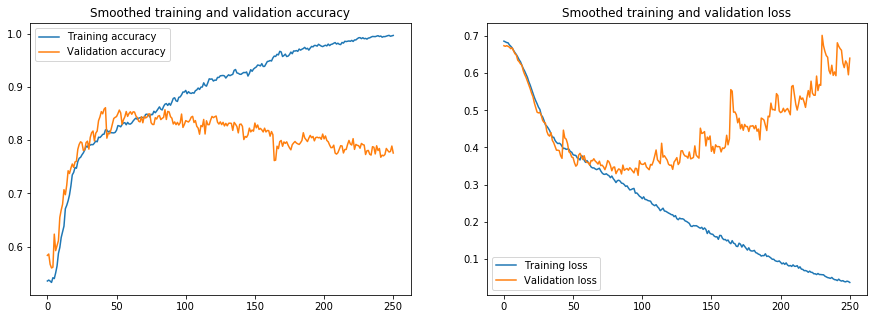

In [12]:
plot_smoothed_acc_and_loss(history, 0.8)

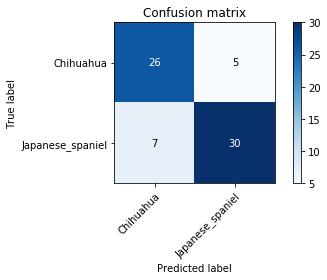

In [13]:
plot_confusion_matrix(y_true=test_labels, 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 2 breeds + data augmentation

### Data preparation

In [14]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 202 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 68 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (68, 100, 100, 3)


### Model

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=3e-5),
              metrics=['accuracy'])

W0628 15:14:44.009969 140284202461056 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_2_data_aug', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_2_data_aug_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 1s - loss: 0.6870 - acc: 0.5300 - val_loss: 0.6865 - val_acc: 0.5333

Epoch 00001: val_loss improved from inf to 0.68650, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_2_data_aug
Epoch 2/1000
 - 1s - loss: 0.6805 - acc: 0.5454 - val_loss: 0.6792 - val_acc: 0.5532

Epoch 00002: val_loss improved from 0.68650 to 0.67924, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_2_data_aug
Epoch 3/1000
 - 1s - loss: 0.6923 - acc: 0.5000 - val_loss: 0.6784 - val_acc: 0.5532

Epoch 00003: val_loss improved from 0.67924 to 0.67836, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_2_data_aug
Epoch 4/1000
 - 1s - loss: 0.6796 - acc: 0.5953 - val_loss: 0.6738 - val_acc: 0.5745

Epoch 00004: val_loss improved from 0.67836 to 0.67375, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_2_data_aug
Epoch 5/1000
 - 1s - loss: 0.6921 - acc: 0.4596 - val_loss: 0.6749 - val_acc: 0.5833

Epoch 0000

### Results

In [17]:
model.evaluate(test_features, test_labels)

68/68 [==============================] - 0s 577us/step


[0.36070938758990345, 0.8823529411764706]

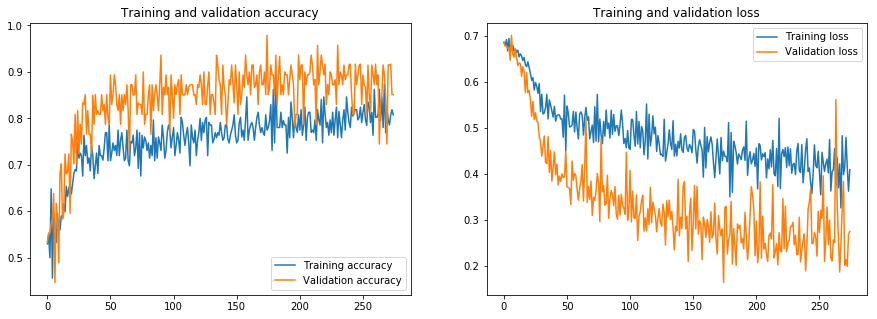

In [18]:
plot_accuracy_and_loss(history)

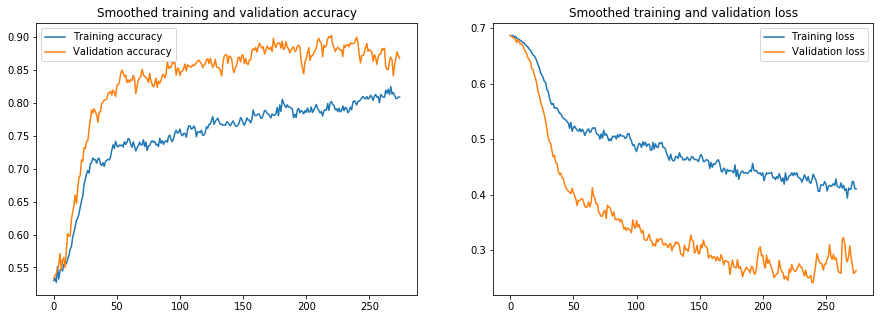

In [19]:
plot_smoothed_acc_and_loss(history, 0.8)

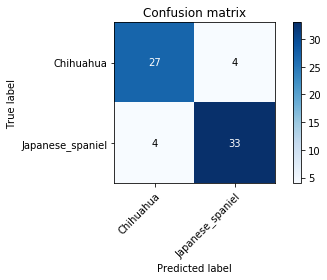

In [20]:
plot_confusion_matrix(y_true=test_labels, 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 3 breeds

### Data preparation

In [21]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 353 images belonging to 3 classes.
Found 117 images belonging to 3 classes.
Found 119 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

Loaded test images in test_features array: (119, 100, 100, 3)


### Model

In [22]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_3', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_3_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 88s - loss: 1.0844 - acc: 0.4147 - val_loss: 1.0798 - val_acc: 0.4500

Epoch 00001: val_loss improved from inf to 1.07984, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_3
Epoch 2/1000
 - 4s - loss: 1.0913 - acc: 0.3682 - val_loss: 1.0966 - val_acc: 0.3402

Epoch 00002: val_loss did not improve from 1.07984
Epoch 3/1000
 - 2s - loss: 1.0783 - acc: 0.4360 - val_loss: 1.0674 - val_acc: 0.4845

Epoch 00003: val_loss improved from 1.07984 to 1.06740, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_3
Epoch 4/1000
 - 2s - loss: 1.0829 - acc: 0.4271 - val_loss: 1.0717 - val_acc: 0.4124

Epoch 00004: val_loss did not improve from 1.06740
Epoch 5/1000
 - 2s - loss: 1.0731 - acc: 0.4359 - val_loss: 1.0744 - val_acc: 0.4536

Epoch 00005: val_loss did not improve from 1.06740
Epoch 6/1000
 - 2s - loss: 1.0771 - acc: 0.4271 - val_loss: 1.0714 - val_acc: 0.4227

Epoch 00006: val_loss did not improve from 1.06740
Epoch 7/1000
 - 2s 

### Results

In [23]:
model.evaluate(test_features, test_labels)

119/119 [==============================] - 0s 1ms/step


[0.6774928349406779, 0.7058823514385384]

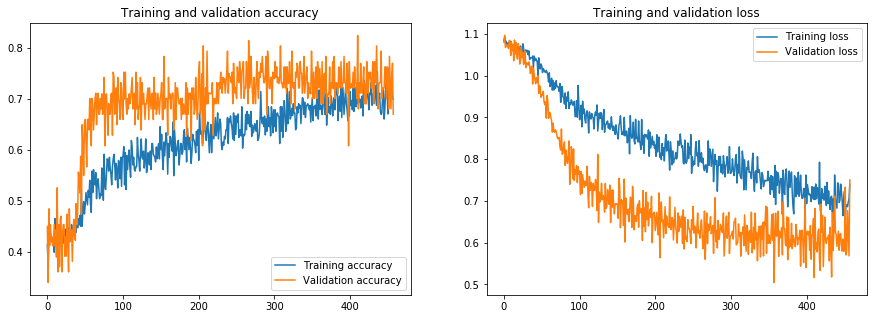

In [24]:
plot_accuracy_and_loss(history)

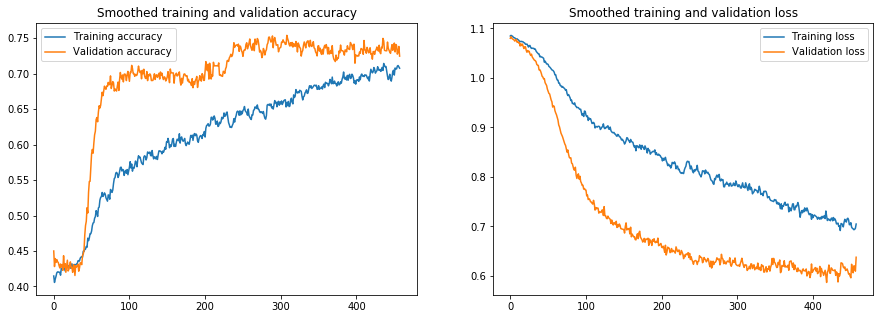

In [25]:
plot_smoothed_acc_and_loss(history, 0.8)

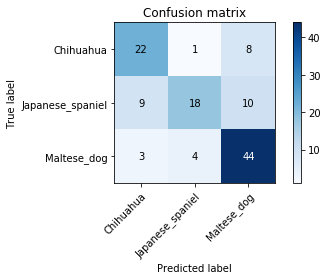

In [26]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 5 breeds

### Data preparation

In [27]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 570 images belonging to 5 classes.
Found 190 images belonging to 5 classes.
Found 192 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

Loaded test images in test_features array: (192, 100, 100, 3)


### Model

In [28]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_5', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_5_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 129s - loss: 1.6112 - acc: 0.1911 - val_loss: 1.6039 - val_acc: 0.1889

Epoch 00001: val_loss improved from inf to 1.60387, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_5
Epoch 2/1000
 - 5s - loss: 1.6034 - acc: 0.2215 - val_loss: 1.5998 - val_acc: 0.2471

Epoch 00002: val_loss improved from 1.60387 to 1.59984, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_5
Epoch 3/1000
 - 3s - loss: 1.5996 - acc: 0.2178 - val_loss: 1.5997 - val_acc: 0.2824

Epoch 00003: val_loss improved from 1.59984 to 1.59975, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_5
Epoch 4/1000
 - 3s - loss: 1.5989 - acc: 0.2464 - val_loss: 1.5913 - val_acc: 0.2176

Epoch 00004: val_loss improved from 1.59975 to 1.59131, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_5
Epoch 5/1000
 - 3s - loss: 1.5937 - acc: 0.2608 - val_loss: 1.5926 - val_acc: 0.3000

Epoch 00005: val_loss did not improve from 1

### Results

In [29]:
model.evaluate(test_features, test_labels)

192/192 [==============================] - 0s 527us/step


[1.2451307376225789, 0.5260416666666666]

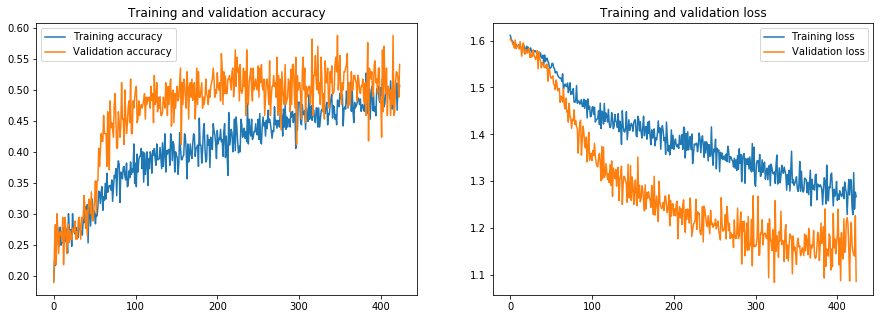

In [30]:
plot_accuracy_and_loss(history)

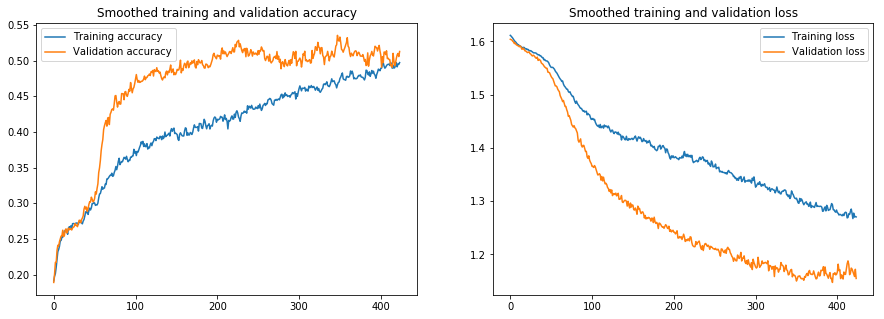

In [31]:
plot_smoothed_acc_and_loss(history, 0.8)

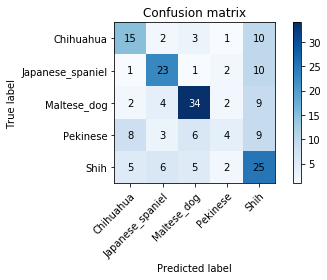

In [32]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 60 breeds

### Data preparation

In [3]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 6046 images belonging to 60 classes.
Found 2019 images belonging to 60 classes.
Found 2046 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

### Model

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_60', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_60_history', 'wb') as f:
    pickle.dump(history.history, f)

W0703 01:12:48.342911  6976 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 01:12:48.361913  6976 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 01:12:48.363913  6976 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 01:12:48.376914  6976 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0703 01:12:48.417916  6976 depreca

Epoch 1/1000
 - 19s - loss: 4.0933 - acc: 0.0219 - val_loss: 4.0808 - val_acc: 0.0260

Epoch 00001: val_loss improved from inf to 4.08084, saving model to cnn_from_scratch_60
Epoch 2/1000
 - 16s - loss: 4.0721 - acc: 0.0265 - val_loss: 4.0059 - val_acc: 0.0320

Epoch 00002: val_loss improved from 4.08084 to 4.00588, saving model to cnn_from_scratch_60
Epoch 3/1000
 - 16s - loss: 3.9833 - acc: 0.0414 - val_loss: 3.8598 - val_acc: 0.0475

Epoch 00003: val_loss improved from 4.00588 to 3.85980, saving model to cnn_from_scratch_60
Epoch 4/1000
 - 16s - loss: 3.9084 - acc: 0.0464 - val_loss: 3.8020 - val_acc: 0.0495

Epoch 00004: val_loss improved from 3.85980 to 3.80201, saving model to cnn_from_scratch_60
Epoch 5/1000
 - 16s - loss: 3.8635 - acc: 0.0536 - val_loss: 3.7181 - val_acc: 0.0775

Epoch 00005: val_loss improved from 3.80201 to 3.71806, saving model to cnn_from_scratch_60
Epoch 6/1000
 - 16s - loss: 3.8382 - acc: 0.0553 - val_loss: 3.6839 - val_acc: 0.0750

Epoch 00006: val_loss 

 - 16s - loss: 3.0206 - acc: 0.2129 - val_loss: 3.0524 - val_acc: 0.1926

Epoch 00053: val_loss improved from 3.09118 to 3.05243, saving model to cnn_from_scratch_60
Epoch 54/1000
 - 16s - loss: 3.0287 - acc: 0.2006 - val_loss: 3.1559 - val_acc: 0.1746

Epoch 00054: val_loss did not improve from 3.05243
Epoch 55/1000
 - 16s - loss: 2.9982 - acc: 0.2128 - val_loss: 3.0666 - val_acc: 0.2006

Epoch 00055: val_loss did not improve from 3.05243
Epoch 56/1000
 - 16s - loss: 3.0136 - acc: 0.2091 - val_loss: 3.1217 - val_acc: 0.1801

Epoch 00056: val_loss did not improve from 3.05243
Epoch 57/1000
 - 16s - loss: 2.9997 - acc: 0.2098 - val_loss: 3.1965 - val_acc: 0.1771

Epoch 00057: val_loss did not improve from 3.05243
Epoch 58/1000
 - 16s - loss: 2.9772 - acc: 0.2160 - val_loss: 3.1111 - val_acc: 0.1866

Epoch 00058: val_loss did not improve from 3.05243
Epoch 59/1000
 - 16s - loss: 2.9800 - acc: 0.2159 - val_loss: 3.0062 - val_acc: 0.2146

Epoch 00059: val_loss improved from 3.05243 to 3.00

 - 16s - loss: 2.5794 - acc: 0.3017 - val_loss: 3.0205 - val_acc: 0.2136

Epoch 00111: val_loss did not improve from 2.85387
Epoch 112/1000
 - 16s - loss: 2.5511 - acc: 0.3129 - val_loss: 2.9127 - val_acc: 0.2316

Epoch 00112: val_loss did not improve from 2.85387
Epoch 113/1000
 - 16s - loss: 2.5601 - acc: 0.3073 - val_loss: 2.8818 - val_acc: 0.2436

Epoch 00113: val_loss did not improve from 2.85387
Epoch 114/1000
 - 16s - loss: 2.5717 - acc: 0.3011 - val_loss: 2.9717 - val_acc: 0.2381

Epoch 00114: val_loss did not improve from 2.85387
Epoch 115/1000
 - 16s - loss: 2.5789 - acc: 0.3051 - val_loss: 3.0482 - val_acc: 0.2181

Epoch 00115: val_loss did not improve from 2.85387
Epoch 116/1000
 - 16s - loss: 2.5248 - acc: 0.3172 - val_loss: 2.9342 - val_acc: 0.2486

Epoch 00116: val_loss did not improve from 2.85387
Epoch 117/1000
 - 16s - loss: 2.5629 - acc: 0.3134 - val_loss: 2.9065 - val_acc: 0.2396

Epoch 00117: val_loss did not improve from 2.85387
Epoch 118/1000
 - 16s - loss: 2.550


Epoch 00168: val_loss did not improve from 2.73522
Epoch 169/1000
 - 16s - loss: 2.3143 - acc: 0.3645 - val_loss: 2.8050 - val_acc: 0.2741

Epoch 00169: val_loss did not improve from 2.73522
Epoch 170/1000
 - 16s - loss: 2.3398 - acc: 0.3644 - val_loss: 2.8299 - val_acc: 0.2751

Epoch 00170: val_loss did not improve from 2.73522
Epoch 171/1000
 - 16s - loss: 2.2879 - acc: 0.3683 - val_loss: 2.9467 - val_acc: 0.2626

Epoch 00171: val_loss did not improve from 2.73522
Epoch 172/1000
 - 16s - loss: 2.3154 - acc: 0.3732 - val_loss: 2.9614 - val_acc: 0.2531

Epoch 00172: val_loss did not improve from 2.73522
Epoch 173/1000
 - 16s - loss: 2.2755 - acc: 0.3807 - val_loss: 2.7624 - val_acc: 0.2866

Epoch 00173: val_loss did not improve from 2.73522
Epoch 174/1000
 - 16s - loss: 2.2779 - acc: 0.3849 - val_loss: 3.0104 - val_acc: 0.2431

Epoch 00174: val_loss did not improve from 2.73522
Epoch 175/1000
 - 16s - loss: 2.2949 - acc: 0.3710 - val_loss: 2.9105 - val_acc: 0.2691

Epoch 00175: val_lo


Epoch 00227: val_loss did not improve from 2.73522
Epoch 228/1000
 - 16s - loss: 2.1527 - acc: 0.4099 - val_loss: 2.8446 - val_acc: 0.2996

Epoch 00228: val_loss did not improve from 2.73522
Epoch 229/1000
 - 16s - loss: 2.1337 - acc: 0.4132 - val_loss: 3.2200 - val_acc: 0.2616

Epoch 00229: val_loss did not improve from 2.73522
Epoch 230/1000
 - 16s - loss: 2.1562 - acc: 0.4038 - val_loss: 2.8562 - val_acc: 0.2846

Epoch 00230: val_loss did not improve from 2.73522
Epoch 231/1000
 - 16s - loss: 2.1468 - acc: 0.4167 - val_loss: 3.0045 - val_acc: 0.2701

Epoch 00231: val_loss did not improve from 2.73522
Epoch 232/1000
 - 16s - loss: 2.1456 - acc: 0.4090 - val_loss: 2.9209 - val_acc: 0.2876

Epoch 00232: val_loss did not improve from 2.73522
Epoch 233/1000
 - 16s - loss: 2.1262 - acc: 0.4072 - val_loss: 3.0615 - val_acc: 0.2731

Epoch 00233: val_loss did not improve from 2.73522
Epoch 234/1000
 - 16s - loss: 2.1372 - acc: 0.4084 - val_loss: 2.9795 - val_acc: 0.2641

Epoch 00234: val_lo

### Results

In [5]:
model.evaluate(test_features, test_labels)

2046/2046 [==============================] - 1s 716us/step


[2.794568540064121, 0.27908113393440975]

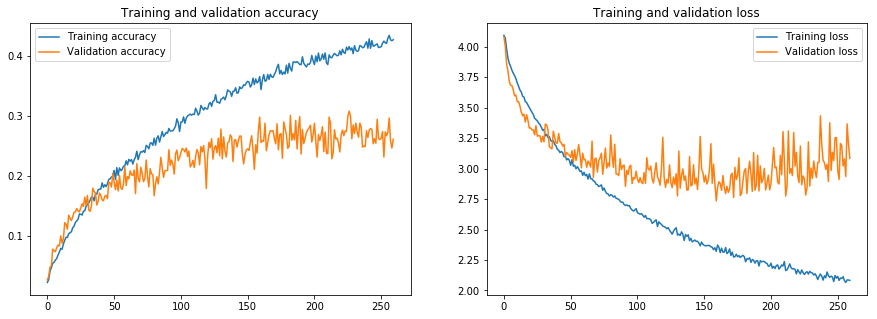

In [6]:
plot_accuracy_and_loss(history)

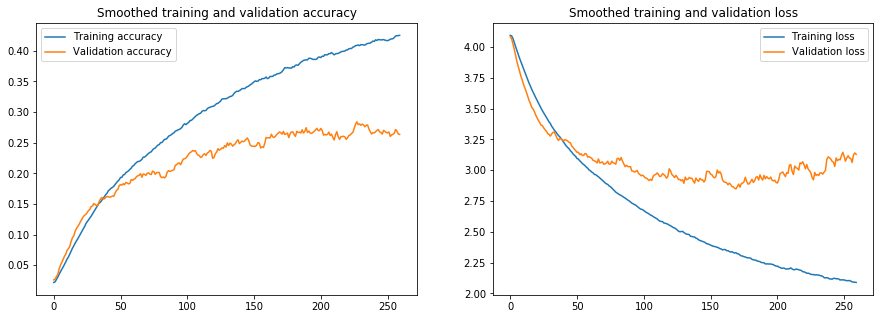

In [7]:
plot_smoothed_acc_and_loss(history, 0.8)

# 120 breeds

### Data preparation

In [33]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 12307 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

### Model

In [34]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-3),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_120', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_120_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 9174s - loss: 4.7724 - acc: 0.0115 - val_loss: 4.6837 - val_acc: 0.0224

Epoch 00001: val_loss improved from inf to 4.68374, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_120
Epoch 2/1000
 - 69s - loss: 4.6317 - acc: 0.0216 - val_loss: 4.4475 - val_acc: 0.0367

Epoch 00002: val_loss improved from 4.68374 to 4.44749, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_120
Epoch 3/1000
 - 68s - loss: 4.4958 - acc: 0.0305 - val_loss: 4.4081 - val_acc: 0.0372

Epoch 00003: val_loss improved from 4.44749 to 4.40813, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_120
Epoch 4/1000
 - 68s - loss: 4.4017 - acc: 0.0397 - val_loss: 4.3237 - val_acc: 0.0482

Epoch 00004: val_loss improved from 4.40813 to 4.32375, saving model to /content/gdrive/My Drive/Colab Notebooks/cnn_from_scratch_120
Epoch 5/1000
 - 68s - loss: 4.3518 - acc: 0.0501 - val_loss: 4.2199 - val_acc: 0.0557

Epoch 00005: val_loss improved 

### Results

In [35]:
model.evaluate(test_features, test_labels)

4162/4162 [==============================] - 2s 468us/step


[3.704497614827997, 0.12950504565112927]

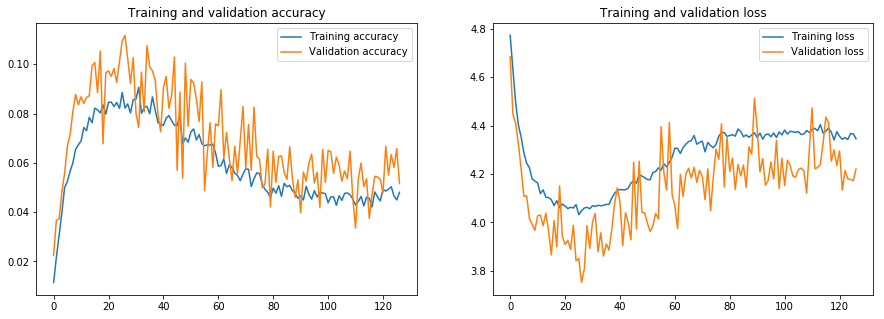

In [36]:
plot_accuracy_and_loss(history)

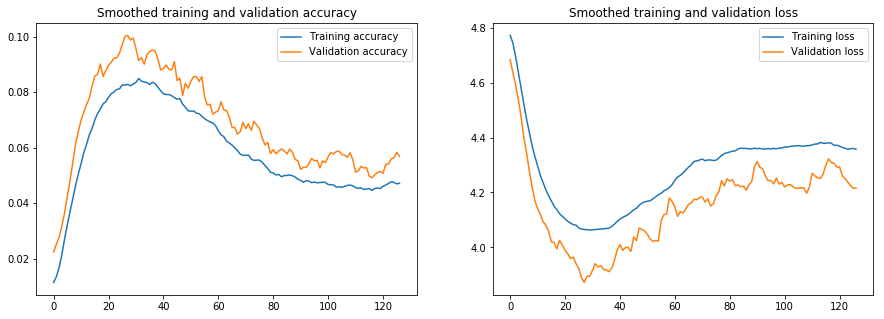

In [37]:
plot_smoothed_acc_and_loss(history, 0.8)